In [102]:
import pandas as pd
from IPython.display import display, HTML

def pprint_pandas(*ser_dfs):
    """在 Jupyter Notebook 中一行并排打印多个 DataFrame 或 Series"""
    df_htmls = []
    for idx, ser_df in enumerate(ser_dfs, start=1):
        if isinstance(ser_df, pd.Series):
            name = ser_df.name if ser_df.name else f"<SERIES {idx}>"
            df_html = pd.DataFrame(ser_df, columns=[name])._repr_html_()
        elif isinstance(ser_df, pd.DataFrame):
            df_html = ser_df._repr_html_()
        else:
            raise TypeError(f"Unsupported type: {type(ser_df)}, value must be a `Series` or a `DataFrame`")
        df_htmls.append(df_html)
    side_by_side_html = f"""
        <div style="display: flex;">
            {"\n".join(f'<div style="margin-right: 20px;">{df_html}</div>' for df_html in df_htmls)}
        </div>
    """
    display(HTML(side_by_side_html))

In [1]:
# load data
from pathlib import Path
import tarfile
import urllib.request

import pandas as pd

def load_housing_data():
    tarball_path = Path("dataset/housing.tgz")
    if not tarball_path.is_file():
        Path("dataset").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="dataset")
    return pd.read_csv("dataset/housing/housing.csv")
housing = load_housing_data()

/var/folders/hp/wjdps1q117gb84t2w2g2552m0000gn/T/ipykernel_83361/3532588023.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="dataset")


In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info() # 数据的快速描述

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# total_bedrooms 有空值
# ocean_proximity 是 Python对象，查看它的分类情况
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
# 查看统计信息
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


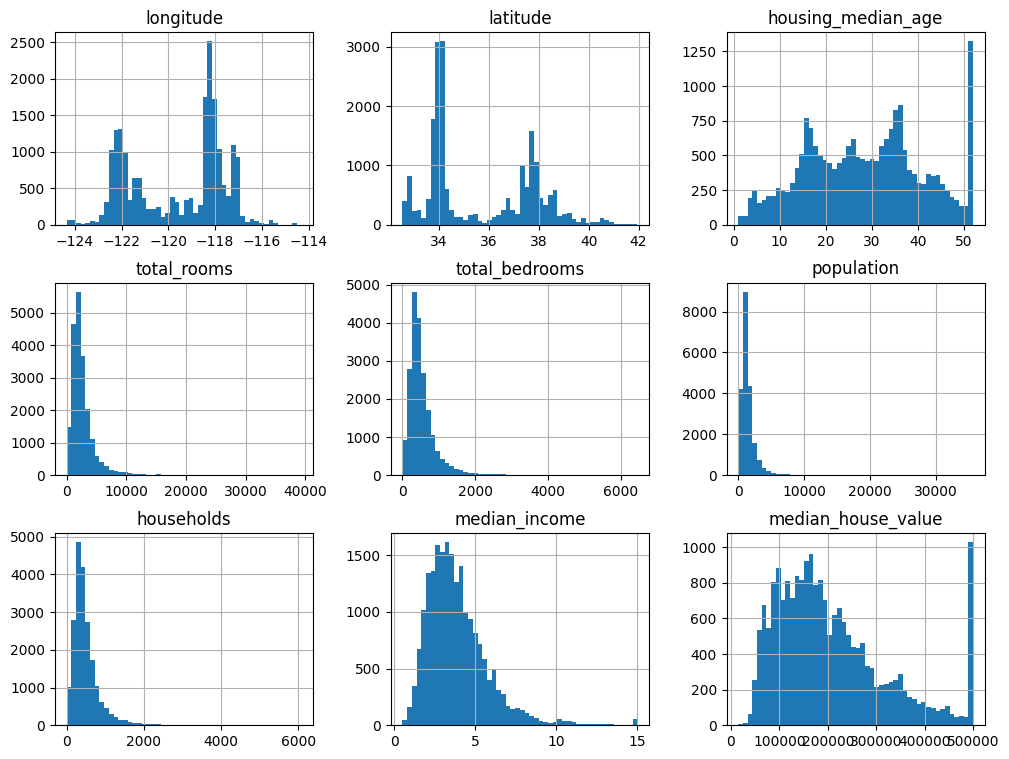

In [12]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12, 9))
plt.show()

In [13]:
import numpy as np

def shuffle_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices] # 训练集，测试集

In [17]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [25]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
train_set.shape, test_set.shape

((16512, 11), (4128, 11))

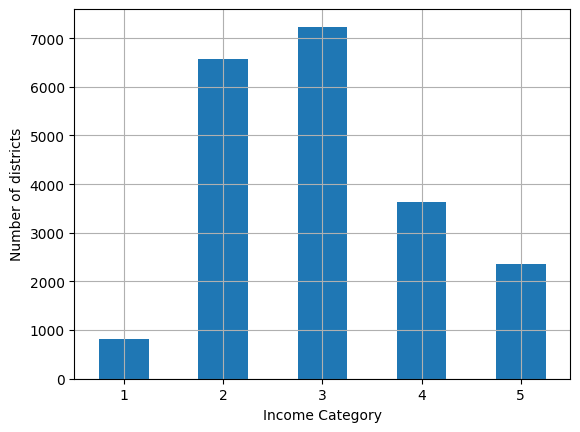

In [33]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=range(1, 6))
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [42]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_indices, test_indices in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_indices]
    strat_test_set = housing.iloc[test_indices]
    strat_splits.append((strat_train_set, strat_test_set))

In [43]:
strat_train_set, strat_test_set = strat_splits[0]

In [57]:
print(strat_test_set["income_cat"].value_counts() / housing["income_cat"].value_counts())

income_cat
3    0.199972
2    0.199970
4    0.200055
5    0.199831
1    0.200730
Name: count, dtype: float64


In [65]:
train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

test_set["income_cat"].value_counts() / test_set.shape[0]

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [67]:
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)
pprint_pandas(train_set, test_set)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


In [68]:
housing = train_set.copy()

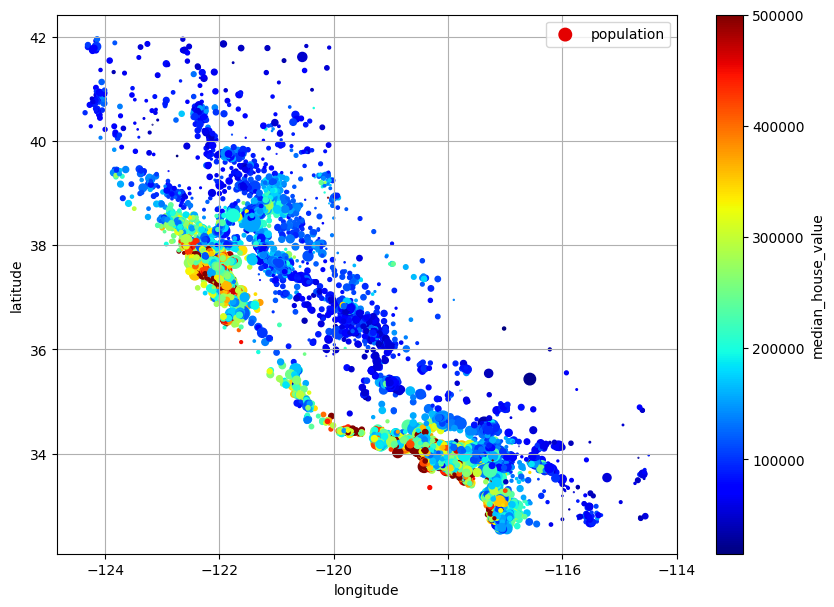

In [72]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
            s=housing["population"] / 100.0, label="population",
            c="median_house_value", cmap="jet", colorbar=True,
            legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [78]:
#housing.drop("ocean_proximity", axis="columns", inplace=True)
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

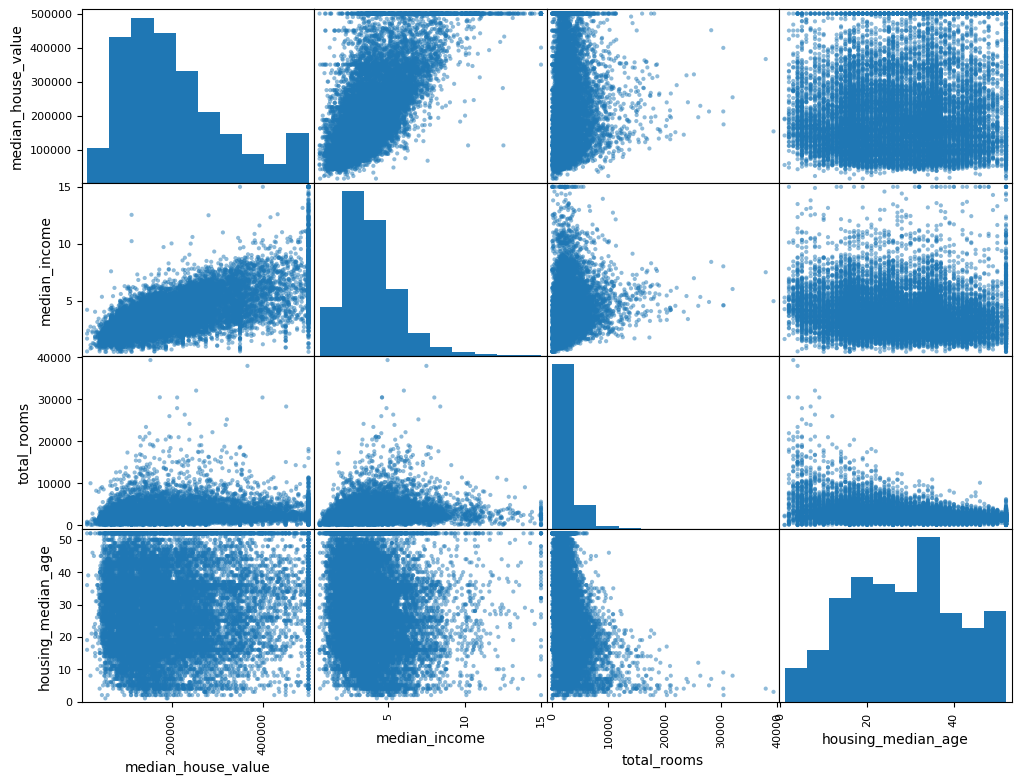

In [79]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 9))
plt.show()

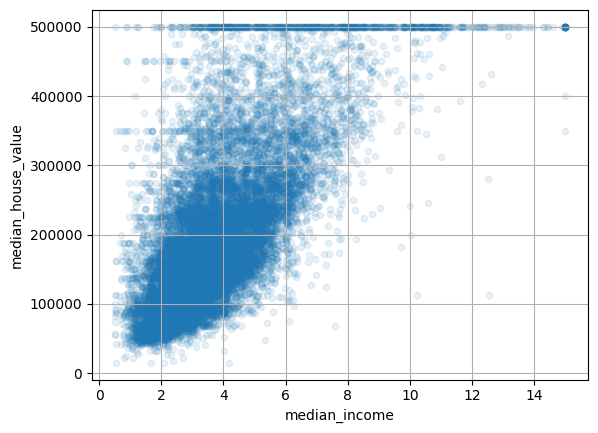

In [81]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

In [83]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,3.725256,0.277371,1.631399


In [84]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [103]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

pprint_pandas(housing, housing_labels)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [104]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [109]:
housing_num = housing.select_dtypes(np.number)

In [110]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [111]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [119]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [120]:
X = imputer.transform(housing_num)

In [129]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
pprint_pandas(housing_tr, housing_tr.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [132]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [141]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_1hot = onehot_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [136]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [144]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
std_scaler = StandardScaler()
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_std_scaler = std_scaler.fit_transform(housing_num)
housing_num_min_max_scaled, housing_num_std_scaler

(array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
         -0.61433638, -0.7794789 ],
        [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
         -0.86708979, -0.22929339],
        [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
         -0.92458466, -0.73336919],
        ...,
        [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
         -0.71663244, -0.50873781],
        [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
         -0.68751167, -0.49716556],
        [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
         -0.92122457, -0.61608805]], shape=(16512, 8)),
 array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
          1.39481249, -0.93649149],
        [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
         -0.37348471,  1.17194198],
        [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
         -0.77572662, -0.75978881],
        ...,
        [ 1.25620853, -1.42870103, -

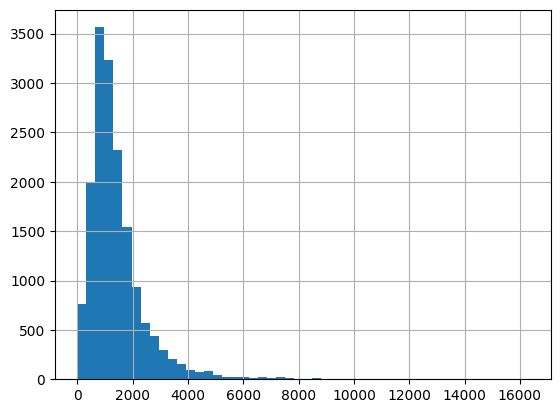

In [147]:
housing_num["population"].hist(bins=50);

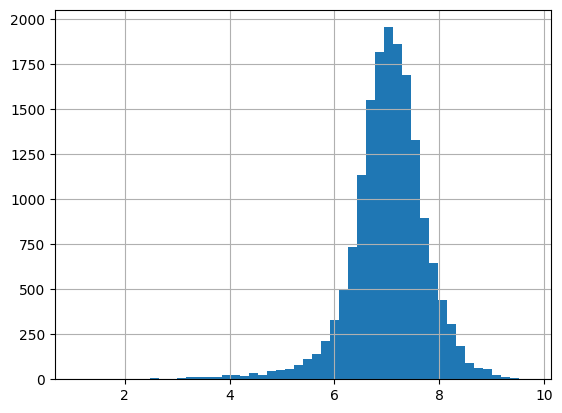

In [149]:
np.log(housing_num["population"]).hist(bins=50);